In [13]:
import pandas as pd

df = pd.read_csv("/Users/ebenezer/Documents/SleepApnea/Alldata/consolidated/summary_all_df.csv", delimiter=",")
df.head(4)

,Subject,Timestamp,Value,Event name,Rank,Post_5,Pre_5,Post_10,Pre_10,Systolic_median,Systolic_mode,SpO2_median,Position_median,HeartRate_median,Diastolic_median
0,1,2024-10-31 22:21:30,0.0,NaN,0,0,0.0,0,0.0,189.0,Wake,0.0,Supine,83.5,125.0
1,1,2024-10-31 22:21:31,0.0,NaN,0,0,0.0,0,0.0,189.5,Wake,0.0,Supine,83.0,124.0
2,1,2024-10-31 22:21:32,0.0,NaN,0,0,0.0,0,0.0,188.0,Wake,92.0,Supine,83.0,121.0
3,1,2024-10-31 22:21:33,0.0,NaN,0,0,0.0,0,0.0,183.0,Wake,92.0,Supine,83.0,120.0


In [14]:
# 2. Identify Obstructive Apnea event start times and start-position for all subjects
oa_events = (
    df[df["Event name"] == "Obstructive Apnea"]
      .sort_values("Timestamp")
      .groupby(["Subject", "Rank"], as_index=False)
      .agg(
          Apnea_Start=("Timestamp", "first"),
          Position_Start=("Position_median", "first")
      )
)
oa_events = oa_events.rename(columns={"Rank": "OA_Rank"})
oa_events.head(3)

,Subject,OA_Rank,Apnea_Start,Position_Start
0,1,2,2024-10-31 22:23:30,Supine
1,1,3,2024-10-31 22:24:26,Supine
2,1,4,2024-10-31 22:25:41,Supine


In [15]:
comparison_subject1

,Subject,OA_Rank,Apnea_Start,Position_Start,Mean_Pre_HR,Mean_Pre_SBP,Max_Post_HR,Max_Post_SBP,Delta_HR,Delta_SBP,Response_Type
0,1,2,2024-10-31 22:23:30,Supine,NaN,NaN,87.0,198.0,NaN,NaN,Divergent
1,1,3,2024-10-31 22:24:26,Supine,92.4,203.7,93.0,207.0,0.6,3.3,Convergent
2,1,4,2024-10-31 22:25:41,Supine,83.3,187.9,87.5,197.0,4.2,9.1,Convergent
3,1,5,2024-10-31 22:27:10,Supine,85.3,186.9,86.0,197.0,0.7,10.1,Convergent
4,1,24,2024-10-31 23:23:58,Right,77.9,197.8,76.0,196.0,-1.9,-1.8,Flat
...,...,...,...,...,...,...,...,...,...,...,...
83,1,286,2024-11-01 09:36:01,Supine,72.9,189.4,72.0,190.0,-0.9,0.6,Divergent
84,1,287,2024-11-01 09:37:31,Supine,70.4,188.7,70.0,201.0,-0.4,12.3,Divergent
85,1,288,2024-11-01 09:38:17,Supine,70.4,185.6,72.0,189.0,1.6,3.4,Convergent
86,1,290,2024-11-01 09:44:55,Supine,72.4,180.0,72.0,195.5,-0.4,15.5,Divergent


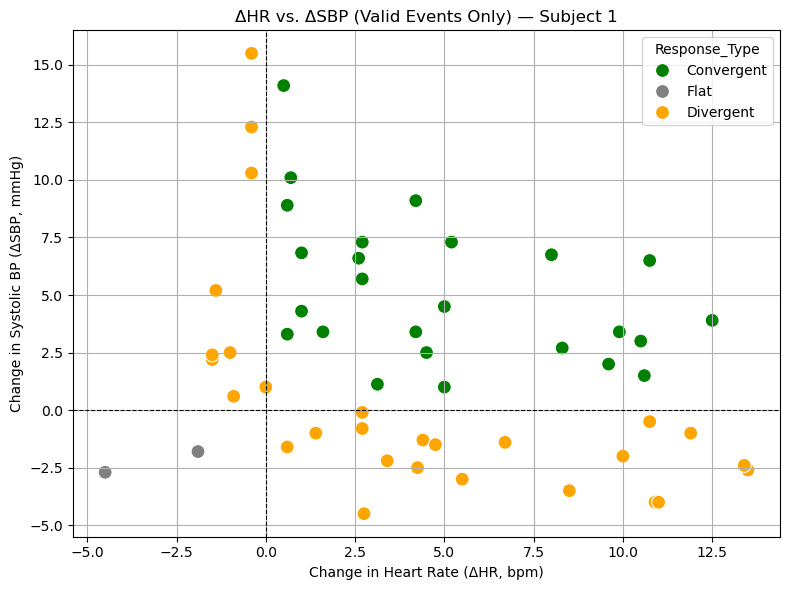

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume df (main dataset) and oa_events are already loaded
subject_id = 1

# Step 1: Clean main data
df_main = df.copy()
df_main = df_main[df_main["HeartRate_median"] > 0]
df_main = df_main[df_main["Systolic_median"] > 0]

# Step 2: Filter events for Subject 1
oa_events_subject1 = oa_events[oa_events["Subject"] == subject_id]

# Step 3: Compute pre-event stats
pre_stats = (
    df_main
    .merge(oa_events_subject1[["Subject", "OA_Rank"]],
           left_on=["Subject", "Pre_5"],
           right_on=["Subject", "OA_Rank"],
           how="inner")
    .groupby(["Subject", "OA_Rank"], as_index=False)
    .agg(
        Mean_Pre_HR=("HeartRate_median", "mean"),
        Mean_Pre_SBP=("Systolic_median", "mean")
    )
)

# Step 4: Compute post-event stats
post_stats = (
    df_main
    .merge(oa_events_subject1[["Subject", "OA_Rank"]],
           left_on=["Subject", "Post_5"],
           right_on=["Subject", "OA_Rank"],
           how="inner")
    .groupby(["Subject", "OA_Rank"], as_index=False)
    .agg(
        Max_Post_HR=("HeartRate_median", "max"),
        Max_Post_SBP=("Systolic_median", "max")
    )
)

# Step 5: Merge everything
comparison_subject1 = (
    oa_events_subject1
    .merge(pre_stats, on=["Subject", "OA_Rank"], how="left")
    .merge(post_stats, on=["Subject", "OA_Rank"], how="left")
)

# Step 6: Compute deltas
comparison_subject1["Delta_HR"] = comparison_subject1["Max_Post_HR"] - comparison_subject1["Mean_Pre_HR"]
comparison_subject1["Delta_SBP"] = comparison_subject1["Max_Post_SBP"] - comparison_subject1["Mean_Pre_SBP"]

# Step 7: Classify events
def classify_response(dhr, dsbp):
    if dhr > 0 and dsbp > 0:
        return "Convergent"
    elif dhr <= 0 and dsbp <= 0:
        return "Flat"
    else:
        return "Divergent"

comparison_subject1["Response_Type"] = comparison_subject1.apply(
    lambda row: classify_response(row["Delta_HR"], row["Delta_SBP"]), axis=1
)

# Step 8: Filter only valid events (non-null and at least one non-zero change)
valid_events = comparison_subject1.dropna(subset=["Delta_HR", "Delta_SBP"])
valid_events = valid_events[(valid_events["Delta_HR"] != 0) | (valid_events["Delta_SBP"] != 0)]

# Step 9: Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=valid_events,
    x="Delta_HR",
    y="Delta_SBP",
    hue="Response_Type",
    palette={"Convergent": "green", "Divergent": "orange", "Flat": "gray"},
    s=100
)

plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.axvline(0, color="black", linestyle="--", linewidth=0.8)

plt.title("ΔHR vs. ΔSBP (Valid Events Only) — Subject 1")
plt.xlabel("Change in Heart Rate (ΔHR, bpm)")
plt.ylabel("Change in Systolic BP (ΔSBP, mmHg)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# Final summary: count and percent of valid events by response type
response_summary = (
    valid_events["Response_Type"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "Response_Type", "Response_Type": "Event_Count"})
    .sort_values("Event_Count", ascending=False)
)


In [24]:
response_summary

,Event_Count,count
2,Flat,2
0,Divergent,28
1,Convergent,25
